In [ ]:
%pip install -qU aiobotocore 
%pip install -q jsonlines

## Data overview and preparation

For this post, you are using the Amazon Berkeley Objects Dataset. The dataset is a collection of 147,702 product listings with multilingual metadata and 398,212 unique catalog images. 8,222 listings come with turntable photography. You will only make use of the item images and item name in US English (which is we consider as the product’s short description). For demo purposes you are going to use about 1,600 products for this practice.
The README file of the dataset can be found in `s3://amazon-berkeley-objects/README.md`, you should be able to download the file to your SageMaker Studio environment by running the following command in a notebook with Python 3 (Data Science) kernel.

In [ ]:
!mkdir -p data
!aws s3 cp --no-sign-request s3://amazon-berkeley-objects/README.md data/README.md 

There are 16 files include product description and metadata, named ` listings/metadata/listings_<i>.json.gz ` . We use the first meta file in the implementation for the demo purposes.

You can use pandas to load metadata, then select products which have titles in US English from the data frame. You will use a column called `main_image_id` to merge item name with item image later.

In [433]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL.Image import Image as PilImage
import textwrap, os
from sagemaker.async_inference.async_inference_config import AsyncInferenceConfig
from sagemaker.serverless.serverless_inference_config import ServerlessInferenceConfig
from sagemaker.serializers import JSONSerializer, IdentitySerializer
from sagemaker.deserializers import JSONDeserializer

In [2]:
s3_bucket_name = "<your-bucket>"
opensearch_url = "<your-opensearch-url>"
opensearch_region = "<your-region>"

In [20]:

meta = pd.read_json("s3://amazon-berkeley-objects/listings/metadata/listings_0.json.gz", lines=True)
def func_(x):
    us_texts = [item["value"] for item in x if item["language_tag"] == "en_US"]
    return us_texts[0] if us_texts else None

meta = meta.assign(item_name_in_en_us=meta.item_name.apply(func_))
meta = meta[~meta.item_name_in_en_us.isna()][["item_id", "item_name_in_en_us", "main_image_id"]]
print(f"#products with US English title: {len(meta)}")
meta.head()

You should be able to see 1639 products in the data frame.
Next, you can link the item names with item images. `images/metadata/images.csv.gz` contains Image metadata. This file is a gzip-compressed comma-separated value (CSV) file with the following columns: `image_id`, `height`, `width`, and `path`. You can read the meta data file and then merge it with item metadata.

In [24]:
image_meta = pd.read_csv("s3://amazon-berkeley-objects/images/metadata/images.csv.gz")
dataset = meta.merge(image_meta, left_on="main_image_id", right_on="image_id")
dataset.head()

,item_id,item_name_in_en_us,main_image_id,image_id,height,width,path
0,B0896LJNLH,AmazonBasics Serene 16-Piece Old Fashioned and...,61izEZdhlaL,61izEZdhlaL,1197,894,07/075e5d67.jpg
1,B07HCR1LSQ,[Find] Amazon Collection Platinum Plated Sterl...,61kDp2x8tPL,61kDp2x8tPL,1000,1000,c9/c923418f.jpg
2,B075DQBBJZ,Arizona Desert Sand Horizon Photo with Wood Ha...,91IjyKZ76qL,91IjyKZ76qL,2560,2560,c6/c6889ed4.jpg
3,B07S74D9T7,AmazonBasics Adjustable Speaker Stand - 3.8 to...,71x4c-BafpL,71x4c-BafpL,2560,2560,2b/2b90e918.jpg
4,B01N27SMXC,Amazon Brand - The Fix Women's Foley Tassel Sl...,71-eMu0gN+L,71-eMu0gN+L,704,1770,2c/2c0416de.jpg


You can have a look at one sample image from the dataset by running the following code

AmazonBasics Serene 16-Piece Old Fashioned and Coolers Glass Drinkware Set


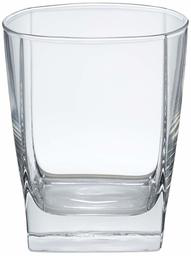

In [425]:
from sagemaker.s3 import S3Downloader as s3down
from pathlib import Path
from PIL import Image


def get_image_from_item_id(item_id = "B0896LJNLH", return_image=True):
    s3_data_root = "s3://amazon-berkeley-objects/images/small/"

    item_idx = dataset.query(f"item_id == '{item_id}'").index[0]
    s3_path = dataset.iloc[item_idx].path
    local_data_root = f'./data/images'
    local_file_name = Path(s3_path).name

    s3down.download(f'{s3_data_root}{s3_path}', local_data_root)

    local_image_path = f"{local_data_root}/{local_file_name}"
    if return_image:
        img = Image.open(local_image_path)
        return img, dataset.iloc[item_idx].item_name_in_en_us
    else:
        return local_image_path, dataset.iloc[item_idx].item_name_in_en_us
image, item_name = get_image_from_item_id()
print(item_name)
image

## Model preparation

You are going to create a SageMaker model from a pretrained CLIP model. The first step is to download a pretrained model weighting files, put it into a model.tar.gz file and upload the file to S3. The path of pretrained model can be found in [CLIP repo](https://github.com/openai/CLIP/blob/main/clip/clip.py#L30). You're going to use a pretrained RN50 model in this POC.

In [36]:
%%writefile build_model_tar.sh
#!/bin/bash

MODEL_NAME=RN50.pt
MODEL_NAME_URL=https://openaipublic.azureedge.net/clip/models/afeb0e10f9e5a86da6080e35cf09123aca3b358a0c3e3b6c78a7b63bc04b6762/RN50.pt

BUILD_ROOT=/tmp/model_path
S3_PATH=s3://clip-store/models/manual-02/model.tar.gz


rm -rf $BUILD_ROOT
mkdir $BUILD_ROOT
cd $BUILD_ROOT && curl -o $BUILD_ROOT/$MODEL_NAME $MODEL_NAME_URL
cd $BUILD_ROOT && tar -czvf model.tar.gz .
aws s3 cp $BUILD_ROOT/model.tar.gz  $S3_PATH

Overwriting build_model_tar.sh


In [37]:
!bash build_model_tar.sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  243M  100  243M    0     0  7072k      0  0:00:35  0:00:35 --:--:-- 16.2M
./
./RN50.pt
tar: .: file changed as we read it
upload: ./model.tar.gz to s3://clip-store/models/manual-02/model.tar.gz


Then you need to provide inference code for the CLIP model. CLIP uses PyTorch for its implementation, so we are going to use [SageMaker PyTorch](https://docs.aws.amazon.com/sagemaker/latest/dg/pytorch.html) framework.  More information related to deploy an PyTorch model with SageMaker can be found [here](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html#deploy-pytorch-models). The inference code accepts two environment variables `MODEL_NAME` and `ENCODE_TYPE`. `MODEL_NAME` helps us to switch between different CLIP model easily. `ENCODE_TYPE` is to specify if you want to encode an image or a piece of text. Here, we implement the `model_fn`, `input_fn`, `predict_fn` and `output_fn` function to override the [default PyTorch inference handler](https://github.com/aws/sagemaker-pytorch-inference-toolkit/blob/master/src/sagemaker_pytorch_serving_container/default_pytorch_inference_handler.py).


In [428]:
!mkdir -p code

In [42]:
%%writefile code/clip_inference.py

import io
import torch
import clip
from PIL import Image
import json
import logging
import sys
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

MODEL_NAME = os.environ.get("MODEL_NAME", "RN50.pt")
# ENCODE_TYPE could be IMAGE or TEXT
ENCODE_TYPE = os.environ.get("ENCODE_TYPE", "TEXT")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# defining model and loading weights to it.
def model_fn(model_dir):
    model, preprocess = clip.load(os.path.join(model_dir, MODEL_NAME), device=device)
    return {"model_obj": model, "preprocess_fn": preprocess}


def load_from_bytearray(request_body):
    
    return image

# data loading
def input_fn(request_body, request_content_type):
    assert request_content_type in (
        "application/json",
        "application/x-image",
    ), f"{request_content_type} is an unknown type."
    if request_content_type == "application/json":
        data = json.loads(request_body)["inputs"]
    elif request_content_type == "application/x-image":
        image_as_bytes = io.BytesIO(request_body)
        data = Image.open(image_as_bytes)
    return data


# inference
def predict_fn(input_object, model):
    model_obj = model["model_obj"]
    # for image preprocessing
    preprocess_fn = model["preprocess_fn"]
    assert ENCODE_TYPE in ("TEXT", "IMAGE"), f"{ENCODE_TYPE} is an unknown encode type."

    # preprocessing
    if ENCODE_TYPE == "TEXT":
        input_ = clip.tokenize(input_object).to(device)
    elif ENCODE_TYPE == "IMAGE":
        input_ = preprocess_fn(input_object).unsqueeze(0).to(device)

    # inference
    with torch.no_grad():
        if ENCODE_TYPE == "TEXT":
            prediction = model_obj.encode_text(input_)
        elif ENCODE_TYPE == "IMAGE":
            prediction = model_obj.encode_image(input_)
    return prediction


# Serialize the prediction result into the desired response content type
def output_fn(predictions, content_type):
    assert content_type == "application/json"
    res = predictions.cpu().numpy().tolist()
    return json.dumps(res)

Writing code/clip_inference.py


In addition, you need to create a `requirements.txt` file which contains dependency for your inferece code.

In [46]:
%%writefile code/requirements.txt
ftfy
regex
tqdm
git+https://github.com/openai/CLIP.git

Overwriting code/requirements.txt


You need create PyTorchModel objects from a saved model artifact and inference entry point. `clip_image_model` will be used to encode images of items and generate embedding through a batch transform job later. `clip_image_model` and `clip_text_model` can be deployed as serverless endpoints later for online inference.

In [50]:
from sagemaker.pytorch import PyTorchModel
from sagemaker import get_execution_role, Session


role = get_execution_role()
shared_params = dict(
    entry_point="clip_inference.py",
    source_dir="code",
    role=role,
    model_data=f"s3://{s3_bucket_name}/models/manual-02/model.tar.gz",
    framework_version="1.9.0",
    py_version="py38",
)

clip_image_model = PyTorchModel(
    env={'MODEL_NAME': 'RN50.pt', "ENCODE_TYPE": "IMAGE"},
    name="clip-image-model",
    **shared_params
)

clip_text_model = PyTorchModel(
    env={'MODEL_NAME': 'RN50.pt', "ENCODE_TYPE": "TEXT"},
    name="clip-text-model",
    **shared_params
)

## Batch transform to generate embedding from item images

CLIP is able to project both images and text into the same latent space, so we only need to encode item images or texts into embedding space. In this practice, you are going to encode item images through a SageMaker Batch Transform job. Before creating the job, you need to copy item images from Amazon Berkeley Objects Dataset public S3 bucket to your own S3 Bucket. The operation needs take less than 10 mins.

In [275]:
%%script echo ignore-the-cell

from multiprocessing.pool import ThreadPool
import boto3
from tqdm import tqdm
from urllib.parse import urlparse

s3_sample_image_root = f"s3://{s3_bucket_name}/sample-images"

client = boto3.client('s3')

def upload_(args):
    client.copy_object(CopySource=args["source"], Bucket=args["target_bucket"], Key=args["target_key"])

arugments = []
for idx, record in dataset.iterrows():
    argument = {}
    argument["source"] = (s3_data_root + record.path)[5:]
    argument["target_bucket"] = urlparse(s3_sample_image_root).netloc
    argument["target_key"] = urlparse(s3_sample_image_root).path[1:] + record.path
    arugments.append(argument)

with ThreadPool(4) as p:
    r = list(tqdm(p.imap(upload_, arugments), total=len(dataset)))

ignore-the-cell


Next, we perform inference on the item images in a batch manner. We set `S3DataType=S3Prefix` to use all objects that match the specified S3 prefix for batch inference. The execution of the job takes around 10 mins.

In [245]:
batch_input = s3_sample_image_root + "/"
output_path = f"s3://{s3_bucket_name}/inference/job_id=01/output"

clip_image_transformer = clip_image_model.transformer(
    instance_count=1,
    instance_type="ml.c5.xlarge",
    strategy="SingleRecord",
    assemble_with="Line",
    output_path=output_path,
)

clip_image_transformer.transform(
    batch_input, 
    data_type="S3Prefix",
    content_type="application/x-image", 
    wait=True,
)

You are going to load embedding from S3 to a notebook variable, so can ingest the data into OpenSearch service later.

In [265]:
from sagemaker.s3 import S3Downloader

embedding_root_path = "./data/embedding"
s3down.download(output_path, embedding_root_path)

embeddings = []
for idx, record in dataset.iterrows():
    embedding_file = f"{embedding_root_path}/{record.path}.out"
    embeddings.append(json.load(open(embedding_file))[0])

## Load OpenSearch Service

### Setting up the Amazon OpenSearch Service domain using KNN settings

First, set up an OpenSearch service cluster. For instructions, see [Creating and Managing Amazon OpenSearch Service Domains](https://docs.aws.amazon.com/opensearch-service/latest/developerguide/createupdatedomains.html).   
Once the Opensearch cluster is set up, create an index to store the item meta data and the embeddings. The index settings must be configured beforehand to enable the KNN functionality using the following configuration:

In [388]:
index_settings = {
  "settings": {
    "index.knn": True,
    "index.knn.space_type": "cosinesimil"
  },
  "mappings": {
    "properties": {
      "embeddings": {
        "type": "knn_vector",
        "dimension": 1024 #Make sure this is the size of the embeddings you generated, for RN50, it is 1024
      }
    }
  }
}

This example uses the Python Elasticsearch client to communicate with the Elasticsearch cluster and create an index to host our data.

In [412]:
import boto3
import json
from requests_aws4auth import AWS4Auth
from elasticsearch import Elasticsearch, RequestsHttpConnection

def get_es_client(host=opensearch_url,
    port=443,
    region=opensearch_region,
    index_name="clip-index"
):

    credentials = boto3.Session().get_credentials()
    awsauth = AWS4Auth(credentials.access_key,
                       credentials.secret_key,
                       region,
                       'es',
                       session_token=credentials.token)

    headers = {"Content-Type": "application/json"}

    es = Elasticsearch(hosts=[{'host': host, 'port': port}],
                       http_auth=awsauth,
                       use_ssl=True,
                       verify_certs=True,
                       connection_class=RequestsHttpConnection,
                       timeout=60 # for connection timeout errors
    )
    return es
es = get_es_client()
es.indices.create(index=index_name, body=json.dumps(index_settings))

# You can check if the index is created within your es cluster
print(es.indices.get_alias("*"))

{'.kibana_1': {'aliases': {'.kibana': {}}},
 'knn-catalog-index': {'aliases': {}},
 'clip-index': {'aliases': {}}}

Next you need to loop through your dataset and ingest items data into the cluster. A more robust and scalable solution for the embedding ingestion can be found in [Ingesting enriched data into Amazon ES](https://aws.amazon.com/blogs/industries/novartis-ag-uses-amazon-elasticsearch-k-nearest-neighbor-knn-and-amazon-sagemaker-to-power-search-and-recommendation/). The data ingestion for this POC should finish within 60 seconds. It also executes a simple query to verify the data have been ingested into the index.

In [305]:
# ingest_data_into_es

for idx, record in tqdm(dataset.iterrows(), total=len(dataset)):
    body = record[['item_name_in_en_us']].to_dict()
    body['embeddings'] = embeddings[idx]
    es.index(index=index_name, id=record.item_id, doc_type='_doc', body=body)

#Check that data is indeed in ES
res = es.search(
    index=index_name, body={
        "query": {
                "match_all": {}
    }},
    size=2)
assert len(res["hits"]["hits"]) > 0

100%|██████████| 1649/1649 [00:33<00:00, 48.88it/s]


## Generate embeddings from the query

Now that you have a working OpenSearch index to contain embeddings for your inventory, let's have a look at how you can generate embedding for new items. You need to create two Amazon SageMaker endpoint for extracting text features and image features. [Amazon SageMaker Serverless Inference](https://docs.aws.amazon.com/sagemaker/latest/dg/serverless-endpoints.html) is a purpose-built inference option that makes it easy for you to deploy and scale ML models. Serverless Inference is ideal for workloads which have idle periods between traffic spurts and can tolerate cold starts. Since you are creating a POC search engine, Serverless Inference is helpful to prevent extra cost. 

You can create two functions to use the endpoints to encode images and texts. For CLIP, you need to perform some `prompt engineering` to translate a item name to a sentence for item description.  Here, `this is <item_name>` is a simple prompt engineering method.

In [356]:
text_predictor = clip_text_model.deploy(
    instance_type='ml.c5.xlarge',
    initial_instance_count=1,
    serverless_inference_config=ServerlessInferenceConfig(memory_size_in_mb=6144),
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer(),
    wait=True
)

image_predictor = clip_image_model.deploy(
    instance_type='ml.c5.xlarge',
    initial_instance_count=1,
    serverless_inference_config=ServerlessInferenceConfig(memory_size_in_mb=6144),
    serializer=IdentitySerializer(content_type="application/x-image"),
    deserializer=JSONDeserializer(),
    wait=True
)

def encode_image(file_name="./data/images/0e9420c6.jpg"):    
    with open(file_name, "rb") as f:
        payload = f.read()
        payload = bytearray(payload)
    res = image_predictor.predict(payload)
    return res[0]

def encode_name(item_name):
    res = text_predictor.predict({"inputs": [f"this is a {item_name}"]})
    return res[0]

You can have a look at the picture you want to encode first, so it could be easier to evaluate the results later.

1024


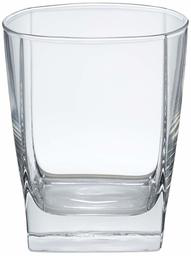

In [437]:
item_image_path, item_name = get_image_from_item_id(item_id = "B0896LJNLH", return_image=False)
feature_vector = encode_image(file_name=item_image_path)

print(len(feature_vector))
Image.open(item_image_path)

## Make a k-nn based query

Let’s take a look at the results of a simple query. After retrieving results from the Opensearch service, we get the item names and images from `dataset`. 

In [439]:
es = get_es_client()

In [442]:
def search_products(embedding, k = 3):
    body = {
        "size": k,
        "_source": {
            "exclude": ["embeddings"],
        },
        "query": {
            "knn": {
                "embeddings": {
                    "vector": embedding,
                    "k": k,
                }
            }
        },
    }        
    res = es.search(index=index_name, body=body)
    images = []
    for hit in res["hits"]["hits"]:
        id_ = hit["_id"]
        image, item_name = get_image_from_item_id(id_)
        image.name_and_score = f'{hit["_score"]}:{item_name}'
        images.append(image)
    return images

def display_images(
    images: [PilImage], 
    columns=2, width=20, height=8, max_images=15, 
    label_wrap_length=50, label_font_size=8):

    if not images:
        print("No images to display.")
        return 

    if len(images) > max_images:
        print(f"Showing {max_images} images of {len(images)}:")
        images=images[0:max_images]

    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))
    for i, image in enumerate(images):

        plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        plt.imshow(image)

        if hasattr(image, 'name_and_score'):
            plt.title(image.name_and_score, fontsize=label_font_size); 
            
images = search_products(feature_vector)

It will be more intuitive if you can show the results with `matplotlib`. As you can see, the first item which score is `1.0` is the same as input, that's the same as we expected, because it's the same as input. Other items are different, but somehow they are similar as the input. For example, the `Push Broom Kit` is black and tall.

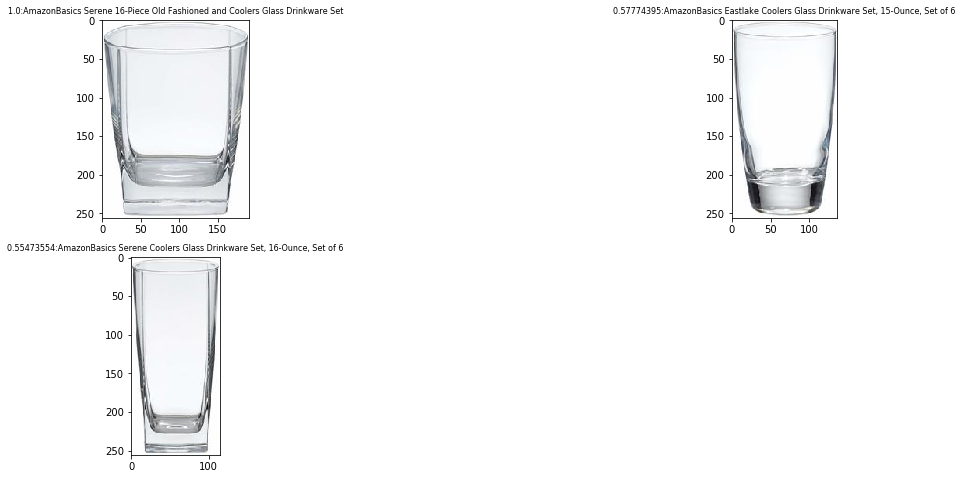

In [443]:
display_images(images)


Now, you can choose a random image from internet can try to find the product in your inventory, for example [link](https://www.amazon.com/AmazonBasics-Ridgecrest-Fashioned-Drinkware-11-5-Ounce/dp/B0896KY57K/ref=sxin_14_trfob_0_B0896KY57K?content-id=amzn1.sym.a9dae892-6c7b-4223-a182-602dedac0323%3Aamzn1.sym.a9dae892-6c7b-4223-a182-602dedac0323&crid=1D85FK9MT47MC&cv_ct_cx=glass&keywords=glass&pd_rd_i=B0896KY57K&pd_rd_r=1e0947c7-d9df-469a-81ef-d69d4f9b1d05&pd_rd_w=leIed&pd_rd_wg=aBAyg&pf_rd_p=a9dae892-6c7b-4223-a182-602dedac0323&pf_rd_r=2Y7FPG6SKBRDTBFVWDGC&qid=1655347998&sprefix=glass%2Caps%2C268&sr=1-1-fcc74f9e-0165-48d2-a9e1-f41ea92a035c). 



![Tux, the Linux mascot](https://m.media-amazon.com/images/I/51B2XFmZIgL._AC_SX679_.jpg)


In [371]:
inferce_example_path = "data/inference_example.png"

In [372]:
!curl -o {inferce_example_path} https://m.media-amazon.com/images/I/51B2XFmZIgL._AC_SX679_.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33999  100 33999    0     0  1037k      0 --:--:-- --:--:-- --:--:-- 1037k


You can see that we found glass drinkware from our `dataset` without providing any textual information. That's what we want to achieve.

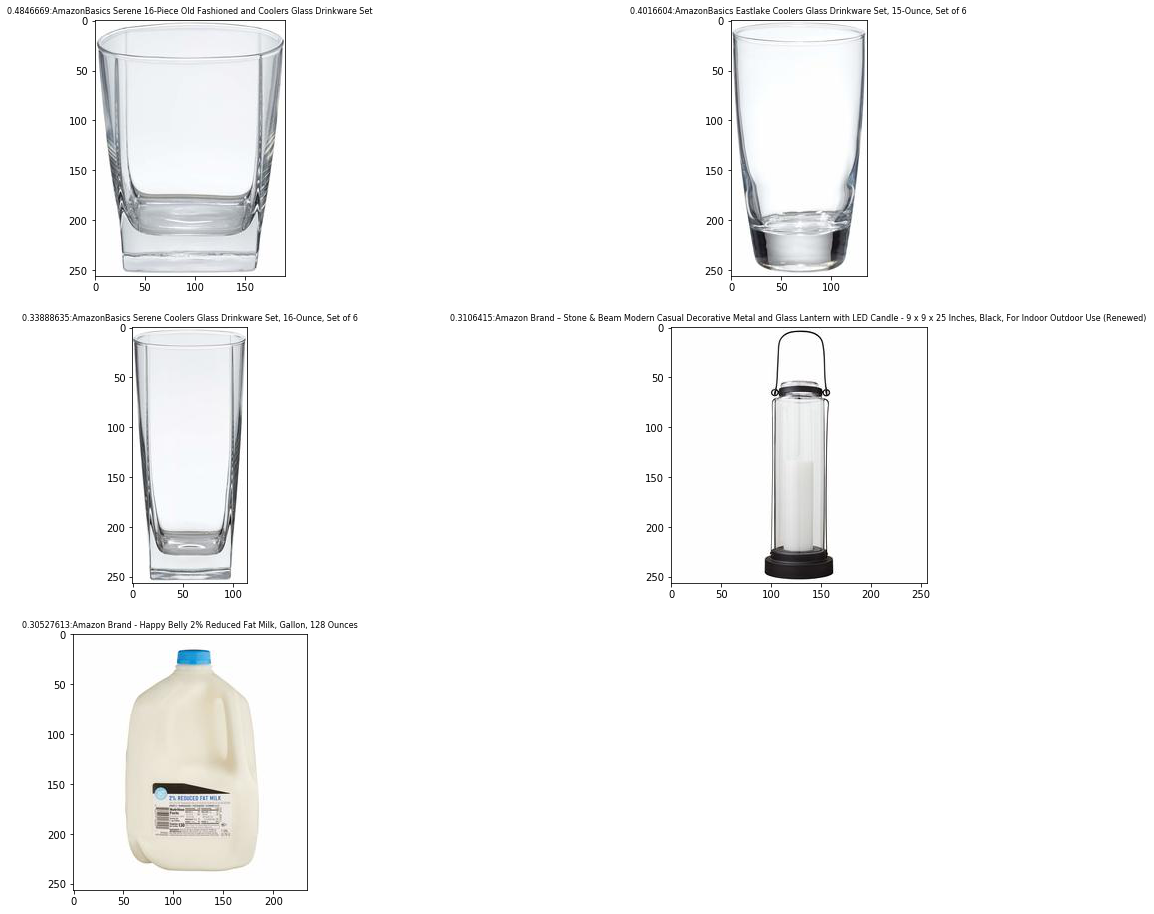

In [373]:
feature_vector = encode_image(file_name=inferce_example_path)
images = search_products(feature_vector)
display_images(images)

This time you can describe the item you want to retrieve in text.

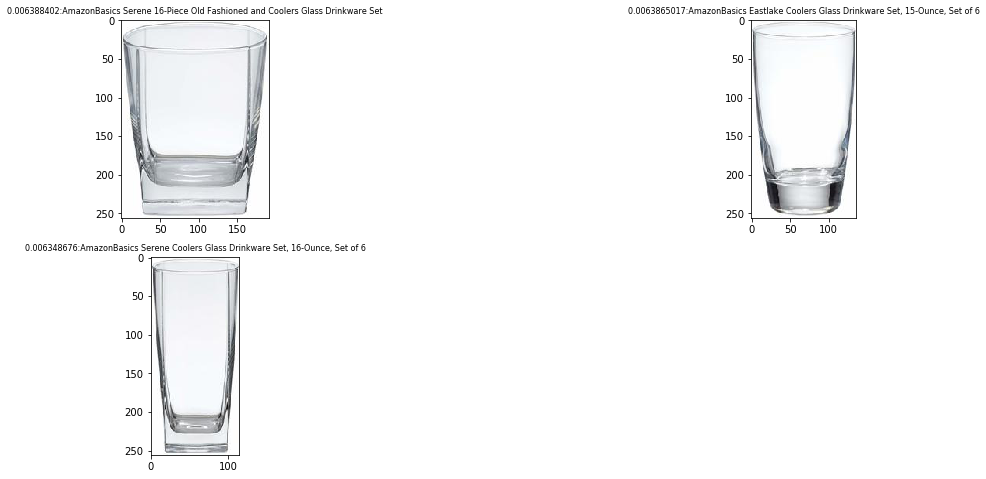

In [457]:
feature_vector = encode_name("drinkware glass")
images = search_products(feature_vector,)
display_images(images)

Now you can try other item description and images as well

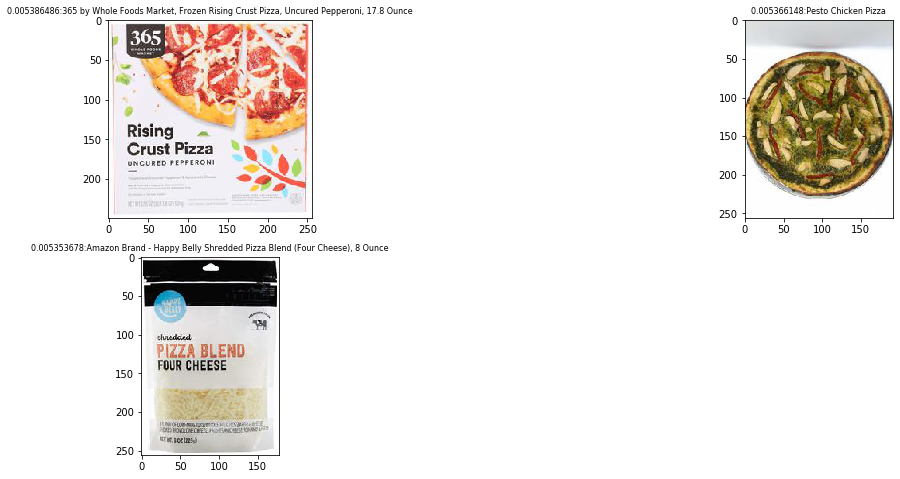

In [470]:
feature_vector = encode_name("pizza")
images = search_products(feature_vector)
display_images(images)

## Cleaning up

With a pay-per-use model, Serverless Inference is a cost-effective option if you have an infrequent or unpredictable traffic pattern. So running endpoints will not charge you, but if you do not plan to use the endpoints, you should delete them to free up some computation resource.

When you finish this exercise, remove your resources with the following steps:

Delete SageMaker Studio user profile and domain.  
Optionally, delete registered models.  
Optionally, delete the SageMaker execution role.  
Optionally, empty and delete the S3 bucket, or keep whatever you want.  

In [ ]:
text_predictor.delete_endpoint()
image_predictor.delete_endpoint()
clip_text_model.delete_model()
clip_image_model.delete_model()